In [9]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split

from tqdm import trange

plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18

In [2]:
def accuracy_score(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [3]:
class LogReg():
    def initialize_params(self, X, Y, epochs, lr):
        self.cost = np.zeros(epochs)
        self.X, self.Y, self.epochs, self.lr = X, Y, epochs, lr
        self.nr_datapoints, self.nr_params = self.X.shape[0], self.X.shape[1]
        self.w, self.b = np.zeros((1, self.nr_params)), 0

    def fit(self, X, Y, epochs, lr):
        self.initialize_params(X, Y, epochs, lr)
        for i in range(epochs):
            dw, db, cost = self.optimize()
            self.w -= lr*dw.T
            self.b -= lr*db
            self.cost[i] = cost
            
    def optimize(self):
        w, b, X, Y, Y_T = self.w, self.b, self.X, self.Y, self.Y.T        
        # Predict results
        Y_pred = sigmoid(np.dot(w, X.T) + b)
        cost = -1/self.nr_datapoints*(np.sum((Y_T*np.log(Y_pred)) + ((1 - Y_T)*(np.log(1 - Y_pred)))))
        # Gradients
        dw = 1/self.nr_datapoints*(np.dot(X.T, (Y_pred-Y_T).T))
        db = 1/self.nr_datapoints*(np.sum(Y_pred-Y_T))
        return dw, db, cost

    def predict(self, X_test):
        Y_pred = sigmoid(np.dot(self.w, X_test.T) + self.b)
        Y_pred = np.where(Y_pred > 0.5, 1, 0)
        return Y_pred

In [4]:
data_pd = pd.read_pickle("../data/credit_card_cleaned.pickle")
data = data_pd.to_numpy(); data_pd

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,0,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21303,210000,1,2,1,34,3,2,2,2,2,...,2500,2500,2500,0,0,0,0,0,0,1
21304,10000,1,3,1,43,0,0,0,0,0,...,0,0,0,2000,0,0,0,0,0,0
21305,80000,1,2,2,34,2,2,2,2,2,...,77519,82607,81158,7000,3500,0,7000,0,4000,1
21306,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0


In [5]:
X = data[:,:-1]
Y = data[:,-1]
nr_params = X.shape[1]; nr_datapoints = Y.shape[0]; nr_params, nr_datapoints

(23, 21308)

In [6]:
epochs = np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800])
lrs = np.array([0, -0.5, -1, -1.5, -2, -2.5, -3, -3.5, -4, -4.5, -5])

In [7]:
nr_averages = 40
acc_mat = np.zeros((len(epochs), len(lrs)))
area_mat = np.zeros((len(epochs), len(lrs)))

for k in range(len(lrs)):
    for j in trange(len(epochs)):
        acc = 0
        area = 0
        for i in range(nr_averages):
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
            Scaler = preprocessing.StandardScaler()
            X_train_scaled = Scaler.fit_transform(X_train)
            X_test_scaled = Scaler.transform(X_test)
            logreg = LogReg()
            logreg.fit(X_train_scaled, Y_train, epochs[j], 10**lrs[k])

            Y_pred = logreg.predict(X_test_scaled)
            acc += accuracy_score(Y_test, Y_pred)
            area += roc_auc_score(Y_test, Y_pred[0])

        acc_mat[j,k] = acc/nr_averages
        area_mat[j,k] = area/nr_averages

100%|██████████| 8/8 [50:16<00:00, 377.01s/it]


In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
Scaler = preprocessing.StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.transform(X_test)
logreg = LogReg()
logreg.fit(X_train_scaled, Y_train, 100, 1e-5)
Y_pred = logreg.predict(X_test_scaled)

In [8]:
np.save("../data/LogReg_acc_2.npy", acc_mat)
np.save("../data/LogReg_area_2.npy", area_mat)

In [7]:
acc_mat = np.load("../data/LogReg_acc_2.npy")
area_mat = np.load("../data/LogReg_area_2.npy")

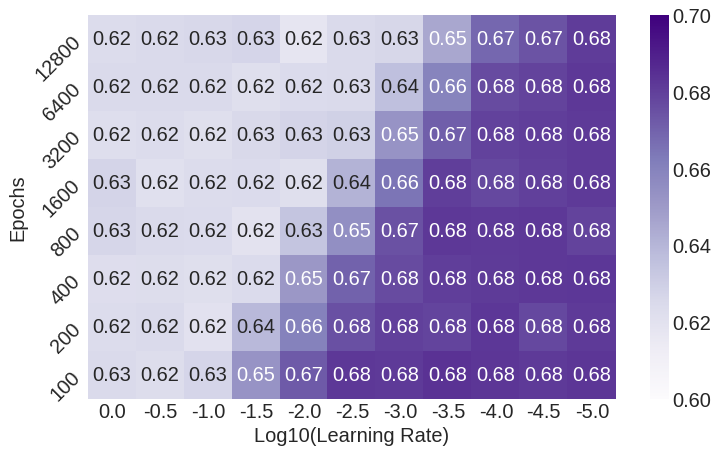

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
sns.heatmap(area_mat, ax=ax, annot=True, fmt=".2f", vmin=0.6, vmax=0.7, xticklabels=lrs, yticklabels=epochs, cmap="Purples", square=True)
ax.set_xlabel("Log10(Learning Rate)")
ax.set_ylabel("Epochs")
plt.ylim(0, len(epochs));
ax.set_yticklabels(epochs, rotation = 45, ha="right")
plt.tight_layout()
#plt.savefig("../figs/CC_logreg_area.pdf", bbox_inches="tight")

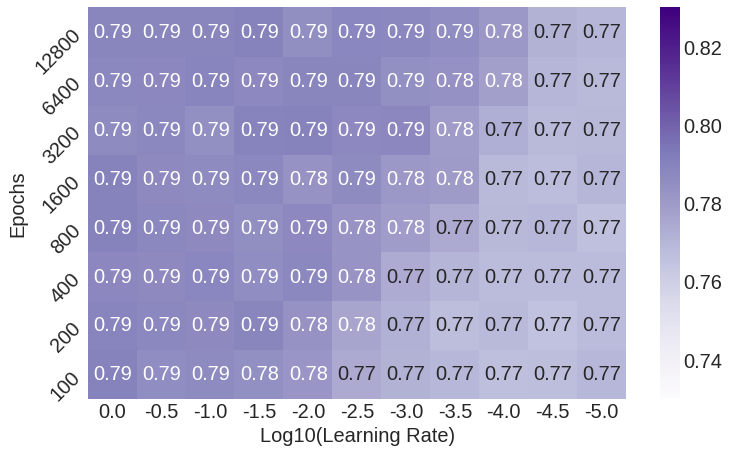

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
sns.heatmap(acc_mat, ax=ax, annot=True, fmt=".2f", vmin=0.73, vmax=0.83, xticklabels=lrs, yticklabels=epochs, cmap="Purples", square=True)
ax.set_xlabel("Log10(Learning Rate)")
ax.set_ylabel("Epochs")
plt.ylim(0, len(epochs));
ax.set_yticklabels(epochs, rotation = 45, ha="right")
plt.tight_layout()
#plt.savefig("../figs/CC_logreg_acc.pdf", bbox_inches="tight")

In [12]:
np.max(area_mat), np.max(acc_mat)

(0.6841688854523843, 0.790497419052088)

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
Scaler = preprocessing.StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.transform(X_test)
logreg = LogReg()
logreg.fit(X_train_scaled, Y_train, 100, 0.1)

Y_pred = logreg.predict(X_test_scaled)